<a href="https://colab.research.google.com/github/vintagedeek/CICIDS2017/blob/master/cicids2017_2020_07_23_96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from collections import OrderedDict, namedtuple
from itertools import product
import time
from IPython.display import display, clear_output
import json

import torch 
from torchvision.transforms import Normalize
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from scipy.ndimage.interpolation import shift
from PIL import Image

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_url = 'https://raw.githubusercontent.com/r-dube/CICIDS2017/master/MachineLearningCVE/processed/bal-cicids2017.csv'
df_train = pd.read_csv(train_url)

In [3]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,YY
0,53,31065,2,2,68,132,34,34,34.0,0.0,66,66,66.0,0.0,1.035500e+04,1.789123e+04,31014,3,3,3.0,0.000000,3,3,48,48.0,0.000000,48,48,0,0,0,0,64,64,64.381136,64.381136,34,66,46.800000,17.527122,307.200000,0,0,0,0,0,0,0,0,1,58.5,34.0,66.0,64,0,0,0,0,0,0,2,68,2,132,-1,-1,1,32,0.0,0.000000,0,0,0.0,0.000000,0,0,0
1,123,67042799,2,2,96,96,48,48,48.0,0.0,48,48,48.0,0.0,2.230000e+07,3.860000e+07,67000000,43166,67000000,67000000.0,0.000000,67000000,67000000,67000000,67000000.0,0.000000,67000000,67000000,0,0,0,0,64,64,0.029832,0.029832,48,48,48.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1,60.0,48.0,48.0,64,0,0,0,0,0,0,2,96,2,96,-1,-1,1,32,43166.0,0.000000,43166,43166,67000000.0,0.000000,67000000,67000000,0
2,53,49637,2,2,180,294,90,90,90.0,0.0,147,147,147.0,0.0,1.654567e+04,2.861464e+04,49587,3,3,3.0,0.000000,3,3,47,47.0,0.000000,47,47,0,0,0,0,64,40,40.292524,40.292524,90,147,112.800000,31.220186,974.700000,0,0,0,0,0,0,0,0,1,141.0,90.0,147.0,64,0,0,0,0,0,0,2,180,2,294,-1,-1,1,32,0.0,0.000000,0,0,0.0,0.000000,0,0,0
3,53,48242,1,1,44,92,44,44,44.0,0.0,92,92,92.0,0.0,4.824200e+04,0.000000e+00,48242,48242,0,0.0,0.000000,0,0,0,0.0,0.000000,0,0,0,0,0,0,20,20,20.728825,20.728825,44,92,60.000000,27.712813,768.000000,0,0,0,0,0,0,0,0,1,90.0,44.0,92.0,20,0,0,0,0,0,0,1,44,1,92,-1,-1,0,20,0.0,0.000000,0,0,0.0,0.000000,0,0,0
4,443,90102413,3,3,18,0,6,6,6.0,0.0,0,0,0.0,0.0,1.802048e+07,2.462721e+07,45000562,34973,90067231,45033615.5,2714.582933,45035535,45031696,90067440,45033720.0,3715.139028,45036347,45031093,0,0,0,0,60,96,0.033295,0.033295,0,6,3.428571,3.207135,10.285714,0,0,0,0,1,0,0,0,1,4.0,6.0,0.0,60,0,0,0,0,0,0,3,18,3,0,251,66,2,20,35379.0,574.170706,35785,34973,44998236.5,3288.753639,45000562,44995911,0


In [4]:
df_train['YY'].value_counts()

0     40000
12     8000
11     8000
10     8000
9      8000
8      8000
7      8000
6      8000
5      8000
4      8000
3      8000
2      8000
1      8000
Name: YY, dtype: int64

In [5]:
df_train.iloc[0:40001]['YY'].value_counts()

0    40000
1        1
Name: YY, dtype: int64

In [6]:
df_train = df_train.iloc[32000:]
df_train = df_train.sample(frac=1).reset_index(drop=True) # Here, specifying drop=True prevents .reset_index from creating a column containing the old index entries.
df_train['YY'].value_counts()
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

12    8000
11    8000
10    8000
9     8000
8     8000
7     8000
6     8000
5     8000
4     8000
3     8000
2     8000
1     8000
0     8000
Name: YY, dtype: int64

In [7]:
y = df_train['YY']
z = df_train.iloc[:, :-1].values
min_max_scaler = preprocessing.MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
df_train = pd.DataFrame(z_scaled)
df_train['YY'] = y

In [8]:
df_train.iloc[:, -1]

0          6
1         11
2          8
3          8
4          1
          ..
103995     1
103996    10
103997     7
103998     7
103999     8
Name: YY, Length: 104000, dtype: int64

In [9]:
train_set = df_train[0:83200]
#z = train_set.iloc[:, :-1].values
#min_max_scaler = preprocessing.MinMaxScaler()
#min_max_scaler.fit(z)
#y = train_set['YY']
#train_set = pd.DataFrame(min_max_scaler.transform(z))
#train_set['YY'] = y
train_set = torch.tensor(np.array(train_set), dtype=torch.float32)
train = torch.narrow(train_set, 1, 0, 76)
train_labels = torch.narrow(train_set, 1, 76, 1)
train_labels = torch.tensor(train_labels, dtype=torch.int64).squeeze() # squeeze to make 1D instead of 2D

val_set = df_train[83200:]
#v = val_set.iloc[:, :-1].values
#vy = val_set['YY']
#val_set = pd.DataFrame(min_max_scaler.transform(v))
#val_set['YY'] = vy
val_set = torch.tensor(np.array(val_set), dtype=torch.float32)
val = torch.narrow(val_set, 1, 0, 76)
val_labels = torch.narrow(val_set, 1, 76, 1)
val_labels = torch.tensor(val_labels, dtype=torch.int64).squeeze()
print(train.shape, train_labels.shape, val.shape, val_labels.shape)

torch.Size([83200, 76]) torch.Size([83200]) torch.Size([20800, 76]) torch.Size([20800])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:
train_labels[80000:80002]

tensor([11,  3])

In [11]:
val_labels[10000:10003]

tensor([9, 8, 6])

In [12]:
val_set[10000:10003, -1]

tensor([9., 8., 6.])

In [13]:
train_labels[45000:45003]

tensor([0, 9, 7])

In [14]:
train_set[45000:45003, -1]

tensor([0., 9., 7.])

In [15]:


x = torch.tensor([[1,2,3], [4,5,6]])
torch.narrow(x, 1, 0, 2)

tensor([[1, 2],
        [4, 5]])

In [16]:
#train = torch.narrow(train_all, 1, 0, 76)
#train_labels = torch.narrow(train_all, 1, 76, 1).squeeze() 
#train_labels = torch.tensor(train_labels, dtype=torch.int64)

In [17]:
#train_labels[10000:10002]

In [18]:
#train_all[10000:10002, -1]

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [20]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        train_accuracy = self.epoch_num_correct / len(train)

        val_accuracy = self.val_correct/len(validation_set)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['train_accuracy'] = train_accuracy
        results['val_accuracy'] = val_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
      
    def track_val_accuracy(self, model):
        with torch.no_grad():
            validation_preds = model(validation_set)
            self.val_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()
   
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [24]:
validation_set = val.to(device)
validation_labels = val_labels.to(device)

params = OrderedDict(
    lr = [0.004],
    batch_size = [8],
    device = ['cuda'],
    weight_decay = [0.0])#, 1.0, 10.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Linear(in_features=76, out_features=26),
        nn.Sigmoid(),
        nn.BatchNorm1d(26),
        nn.Linear(in_features=26, out_features=13),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    m.begin_run(run, network)
    for epoch in range(130):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,2.306713,0.759663,0.809760,12.927616,12.927624,0.04,8,cuda,0.0
1,1,2,2.271777,0.767776,0.762692,12.776908,25.733067,0.04,8,cuda,0.0
2,1,3,2.270403,0.790769,0.782212,12.923951,38.684012,0.04,8,cuda,0.0
3,1,4,2.273617,0.746719,0.815048,13.264088,51.977292,0.04,8,cuda,0.0
4,1,5,2.281638,0.759940,0.776827,13.469940,65.476236,0.04,8,cuda,0.0
5,1,6,2.274276,0.759411,0.832837,12.950185,78.454294,0.04,8,cuda,0.0
6,1,7,2.286409,0.736286,0.687885,13.166167,91.649689,0.04,8,cuda,0.0
7,1,8,2.281724,0.734363,0.816346,13.063687,104.744966,0.04,8,cuda,0.0
8,1,9,2.273503,0.766346,0.849808,13.139236,117.913327,0.04,8,cuda,0.0
9,1,10,2.287286,0.751466,0.759760,13.417855,131.362272,0.04,8,cuda,0.0


KeyboardInterrupt: ignored

In [139]:
m.save('cicids_batch_lr_grid_search_validation')

# Best Run Data
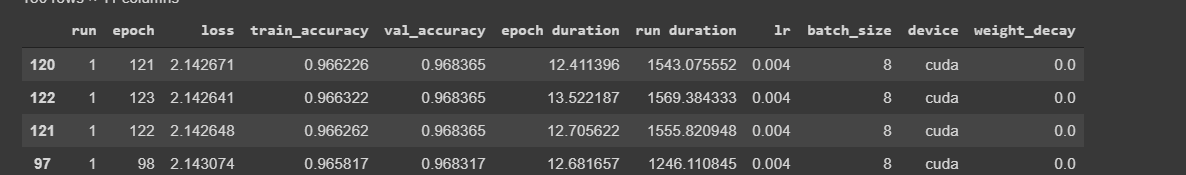


In [97]:
m.val_correct

0

In [98]:
x=network(validation_set)

In [100]:
val_corr = 0
val_corr += x.argmax(dim=1).eq(validation_labels).sum().item()

In [108]:
x.argmax(dim=1)[999:1043]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       device='cuda:0')

In [110]:
validation_labels

tensor([10, 10, 10,  ..., 12, 12, 12], device='cuda:0')